# Práctica 1: Gradient descent con tensor flow

**Curso:** Statistical Learning

**Catedrático:** Ing. Luis Leal

**Estudiante:** Dany Rafael Díaz Lux (21000864)

**Instrucciones:** La tarea práctica consiste en usar el mismo dataset del proyecto del curso pasado y e implementar gradient descent aplicado a regresión con este. (usando la variable con mayor correlación elegida en el proyecto en anterior) El entrenamiento con gradient descent debe usar tensorflow y usar tensorboard para monitorear que el error disminuya conforme avanzan las iteraciones "en vivo".

Utilizar tensorboard:
- Agregar el grafo del modelo.
- Usar operaciones con nombre y usar name_spaces para mejorar el orden.
- Agregar un summary.scalar para monitorear el MSE.
- Aplicar reutilización de código: por ejemplo usar programación orientada a objetos para crear el modelo y/o definir el entrenamiento dentro de funciones de python.
- Utilizar las funciones reutilizables de entrenamiento para ejecutar al menos 10 experimentos (variable numero de iteraciones, diferente learning rate y diferente tamaño de mini-batch)
- definir un string de configuración para cada experimento.
- crear un directorio para cada experimento basado en el string de configuración.
- utilizar un enfoque investigación científica: antes del experimento formular una hipótesis del comportamiento esperado, ejecutar el experimento y utilizar los resultados de tensorboard para conculir.
- basado en los resultados experimentales obtenidos con tensorboard crear una conclusión general y elegir el mejor experimento.
- agregar el contenido de tensorboard al notebook(pueden ser screenshots=
- subir el notebook a github y agregar al GES el link
- no utilizar tf.train.GradientDescentOptimizer ni tf.losses

In [188]:
# Import required libraries and enable compatibility with tensor flow 1
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pylab as plt
import datetime as dt

if tf.__version__.startswith("2."):
  import tensorflow.compat.v1 as tf
  tf.compat.v1.disable_v2_behavior()
  tf.compat.v1.disable_eager_execution()
  print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


In [189]:
# Cargar matriz de datos
datosCasas = np.load('proyecto_training_data.npy')

# Sólo se realizará entrenamiento con gradient descente, por lo que se usará toda la información como entrenamiento
porcentajeEntrenamiento = 1
limiteEntrenamiento = int(datosCasas.shape[0] * porcentajeEntrenamiento)
datosEntrenamiento = datosCasas[:limiteEntrenamiento,]


### Elección de variable con más potencial predictivo
La variable con mayor potencial predictivo (que tiene mayor coeficiente de correlación) es:

* **Calidad general de casa**: Número de 1 a 10 que indica la calidad final de una casa. (Coeficiente de correlación: 0.794)

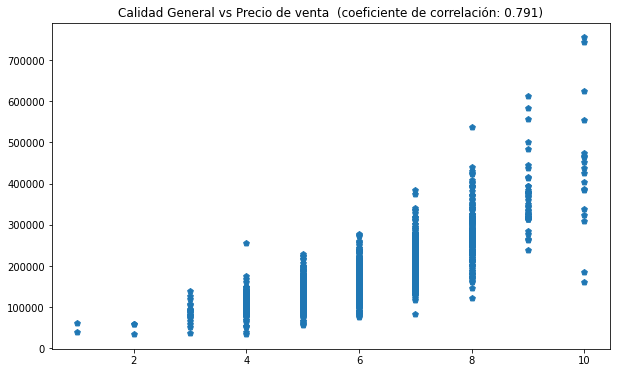

In [6]:
# Vector con la variable elegida
nombresVariables = np.array(['Precio de venta', 'Calidad General'])

# Realizar gráfica de dispersión con la variable de precio de venta como variable dependiente.
# Mostrar coeficiente de correlación como parte del título de la gráfica
for iVar in range(1, len(nombresVariables)):
    varVector = datosEntrenamiento[:,iVar]
    varDep = datosEntrenamiento[:,0]
    df = pd.DataFrame(datosEntrenamiento[:,[0,iVar]])
    coef = round(df.corr()[0][1],4)
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_subplot(1,1,1)
    ax.set_title(nombresVariables[iVar] + ' vs ' + nombresVariables[0] + '  (coeficiente de correlación: ' + str(coef) + ')')
    ax.scatter(varVector, varDep, marker='p')
    plt.show()
    print('')


In [243]:
# Utilizando código compartido en Clase para crear modelo con TensorFlow
class ModeloLineal:
    def __init__(self):
        self.vectorMb = tf.Variable([[0.0, 0.0]], name="VectorMB")
        
    def __call__(self,matrizX):
        return tf.matmul(self.vectorMb, matrizX)
    
    def actualizar(self,matrizX,y,learning_rate):
        with tf.name_scope("Prediccion"):
            prediccion = self(matrizX)
        
        with tf.name_scope("Error"):
            error = (1.0/2.0) * tf.reduce_mean(tf.math.square(y - prediccion))
            error_summary = tf.summary.scalar("Error", error)
        
        with tf.name_scope("Gradiente"):
            gradiente = tf.gradients(error, self.vectorMb)
        
        with tf.name_scope("Actualizar_M_B"):
            multGradLr = tf.math.multiply(gradiente, learning_rate)
            restaVectorMb = tf.math.subtract(self.vectorMb, multGradLr)
            actualizacion_Mb = tf.assign(self.vectorMb, restaVectorMb[0])

        return error_summary, error, actualizacion_Mb

In [253]:
def modeloLinealMiniBatch(x, y, epochs, learningRate, batchSize):
    cantidadDatos = x.shape[1]
    totalIteraciones = int(cantidadDatos/batchSize)
    g = tf.Graph()
    with g.as_default():
        modelo = ModeloLineal()
        tensorX = tf.placeholder(tf.float32,[x.shape[0], None],"tensorX")
        tensorY = tf.placeholder(tf.float32,[None],"tensorY")
        calcularPrediccion = modelo(tensorX) #Esto creará la definición para la operación y = mx + b
        actualizarParametros = modelo.actualizar(tensorX, tensorY, learningRate) # Definición para actualizar parámetros
        directorioModelo = './summaries/' + dt.datetime.now().strftime("%Y%m%d-%H%M%S") + '_RegresionLinealMiniBatchGradientDescent' \
            + '_epochs=' + str(epochs) + '_lr=' + str(learningRate) + '_batchSize=' + str(batchSize)

        with tf.train.MonitoredSession() as session:
            writer = tf.summary.FileWriter(directorioModelo, g)
            for epoch in range(epochs):
                for batch in range(totalIteraciones):
                    inicioBatch = batch * batchSize
                    finBatch = inicioBatch + batchSize - 1
                    if (cantidadDatos - finBatch) < batchSize:
                        finBatch = cantidadDatos - 1
                    miniBatchX =  np.array(x[:,inicioBatch:finBatch])
                    miniBatchY = np.array(y[inicioBatch:finBatch])
                    # Realizar la actualización de parámetros por mini batch
                    feed_dict = {tensorX: miniBatchX, tensorY: miniBatchY}
                    # Si no es la última iteración sólo correr actualización de parámetros
                    if batch != totalIteraciones - 1:
                        session.run(actualizarParametros,feed_dict=feed_dict)
                    # De lo contrario obtener error final de epoch y vectorMB
                    else:
                        errorSummary, error, vectorMb = session.run(actualizarParametros,feed_dict=feed_dict)
                        
                # Añadir error a summary de tensorboard
                writer.add_summary(errorSummary,epoch)
                
                # Calcular predicción con parámetros actualizados (después de todos los mini batchs)
                feed_dict = {tensorX: x, tensorY: y}
                predicciones = session.run(calcularPrediccion,feed_dict=feed_dict)

            vectorMb = session.run(modelo.vectorMb,feed_dict=feed_dict)[0]
            writer.close()
    
    print('Modelo MiniBatch. Epochs: ', epochs, ', learning rate: ', learningRate, ', Batch size: ', batchSize, \
          ', Error final: ', error/1000000, ' millones ; y = ' + str(vectorMb[0]) + 'x + '+ str(vectorMb[1]))

### Diagrama del Grafo generado

A continuación se muestra el grafo generado por TensorBoard del modelo lineal por mini batch gradient descent: 

![Grafo generado por TensorBoard](https://github.com/DanyDiaz/statistical-learning/blob/master/Practica%201%20-%20Gradient%20descent%20en%20TensorFlow/DiagramaGrafo_ModeloLinealMiniBatchGradientDescent.png)


### Hipótesis
La variación de los hiperparámetros: epochs, learning rate y batch size producirá diferentes magnitudes de errores finales; se verá que combinación de los mismos produce una mejor reducción. Se medirán 3 opciones de cada uno (valor pequeño, normal, grande) para observar algun indicio de qué posible valor sería mejor colocar. 

In [254]:
# Preparación de matriz X
x_calidadGeneral = datosEntrenamiento[:,1]
onesVector = np.ones_like(x_calidadGeneral)
matrizX_CalidadGeneral = np.array([x_calidadGeneral, onesVector])
# Vector Y
y_precioCasa = datosEntrenamiento[:,0]
# Variaciones de valores para learning rate
learning_rates = [0.001, 0.02, 0.1]
epochs = [100, 500, 1000]
bSizes = [4, 64, 512]

for lr in learning_rates:
    for ep in epochs:
        for bSize in bSizes:
            modeloLinealMiniBatch(matrizX_CalidadGeneral, y_precioCasa, ep, lr, bSize)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  100 , learning rate:  0.001 , Batch size:  4 , Error final:  552.752832  millones ; y = 43029.14x + -79945.39
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  100 , learning rate:  0.001 , Batch size:  64 , Error final:  1128.39232  millones ; y = 31308.98x + -5547.983
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  100 , learning rate:  0.001 , Batch size:  512 , Error final:  1478.31616  millones ; y = 29846.908x + 3668.9526
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  500 , learning rate:  0.001 , Batch size:  4 , Error final:  546.407744  millo

### Gráficas brindadas por TensorBoard en estas primeras ejecuciones

![Primeras gráficas de disminución de error](https://github.com/DanyDiaz/statistical-learning/blob/master/Practica%201%20-%20Gradient%20descent%20en%20TensorFlow/GraficaMSE.png)

### Primeras inferencias que se obtuvieron de las primeras corridas:

* El número de epochs se dejará sólo en el mayor (1000) pues se en las gráficas dadas por TensorBoard, se puede ver que un número menor de epochs se puede ver en sus "steps" anteriores.
* Se puede ver en los errores finales que el learning rate debe ser bajo o de lo contrario el error y parámetros se vuelven demasiado grandes.
* Parece ser que un tamaño bajo de batch size ayuda a minimizar el error final.

Se realizarán una ronda extra de experimentos para corroborar estas inferencias.

In [255]:
# Variaciones de valores para learning rate
learning_rates = [0.001, 0.005, 0.01]
epochs = [1000]
bSizes = [4, 8, 16]

for lr in learning_rates:
    for ep in epochs:
        for bSize in bSizes:
            modeloLinealMiniBatch(matrizX_CalidadGeneral, y_precioCasa, ep, lr, bSize)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  1000 , learning rate:  0.001 , Batch size:  4 , Error final:  546.407744  millones ; y = 45747.27x + -97118.375
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  1000 , learning rate:  0.001 , Batch size:  8 , Error final:  433.653728  millones ; y = 46085.113x + -99928.26
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  1000 , learning rate:  0.001 , Batch size:  16 , Error final:  571.40256  millones ; y = 45455.246x + -96150.34
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  1000 , learning rate:  0.005 , Batch size:  4 , Error final:  701.733568  mi

### Pruebas finales
Basado en la gráfica de abajo el tamaño del batch debe ser un valor cercano a 8 (se probará con los valores 8, 10 y 12) y que el learning rate debe ser mayor a 0.001 pero menor a 0.01 (se probarán con valores 0.003, 0.005, 0.007). También se tomará como límite de epochs 500 porque se ve que después de este valor ya no baja mucho el error.

![Más gráficas de disminución de error](https://github.com/DanyDiaz/statistical-learning/blob/master/Practica%201%20-%20Gradient%20descent%20en%20TensorFlow/GraficaMSE_2.png)

In [256]:
# Variaciones de valores para learning rate
learning_rates = [0.003, 0.005, 0.007]
epochs = [500]
bSizes = [8, 10, 12]

for lr in learning_rates:
    for ep in epochs:
        for bSize in bSizes:
            modeloLinealMiniBatch(matrizX_CalidadGeneral, y_precioCasa, ep, lr, bSize)

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  500 , learning rate:  0.003 , Batch size:  8 , Error final:  432.657216  millones ; y = 46209.348x + -100195.52
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  500 , learning rate:  0.003 , Batch size:  10 , Error final:  410.124352  millones ; y = 45184.28x + -93546.7
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  500 , learning rate:  0.003 , Batch size:  12 , Error final:  596.391424  millones ; y = 45588.258x + -96202.15
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Modelo MiniBatch. Epochs:  500 , learning rate:  0.005 , Batch size:  8 , Error final:  432.259904  millo

### Conclusiones

El mejor modelo encontrado es: _y = 45184.28x - 93546.7_ que tiene un costo de 410124352. Este modelo se alcanzó utilizando el algoritmo de mini-batch gradient descent con los hiper parámetros: número de epochs de 500, learning rate de 0.003 y batch size de 10.

![Gráficas finales](https://github.com/DanyDiaz/statistical-learning/blob/master/Practica%201%20-%20Gradient%20descent%20en%20TensorFlow/GraficaMSE_3.png)